# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 297 (delta 37), reused 6 (delta 1), pack-reused 226
Receiving objects: 100% (297/297), 13.05 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import statistics
import torch
import math
import sklearn
import scipy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from platform import python_version
from torch import Tensor, float32, sin, cos
from google.colab import files

import utils_bsc

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:

print('versions of packages:')
print(f'Python: {python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'PyTorch: {torch.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'scipy: {scipy.__version__}')

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2
scipy: 1.4.1


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False
print_graphs = False

In [7]:
if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [8]:
if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [9]:
# We print some graphs showing the density distribution of every feature
if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [10]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [11]:
if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [12]:
if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [13]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [14]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 759.06it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1270.74it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1066.55it/s]


In [17]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [18]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [19]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


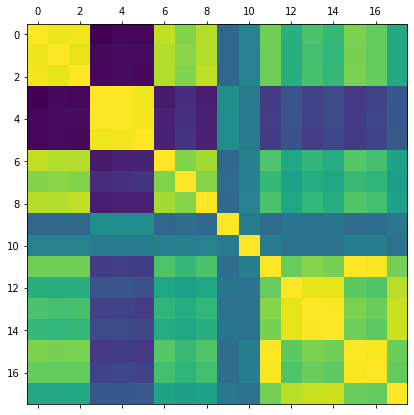

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810275, 0.16335739298653454, 0.07511546472383007, 0.054921627068028396, 0.05390616867076576, 0.04952232661739347, 0.02248634946399557, 0.013932731902136307, 0.012792662672300404, 0.00982901200719907, 0.004024926426955618, 0.0028939596101033747, 0.002163271201445894, 0.001741116222641514, 0.0006928432299861942, 0.000218263374261013, 0.00023351820917082356, 0.00040358513222439905]


In [20]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [21]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686161
Correlation between PLN1 and PLN3
0.9606664987977855
Correlation between PLN1 and ULL1
-0.7274016376341781
Correlation between PLN1 and ULL2
-0.6955282277514698
Correlation between PLN1 and ULL3
-0.7030835410050383
Correlation between PLN1 and COS_PHI1
0.841040129519536
Correlation between PLN1 and COS_PHI2
0.6731338062873105
Correlation between PLN1 and COS_PHI3
0.8122370309192151
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090617
Correlation between PLN1 and RC_AC
0.6311099014117805
Correlation between PLN1 and RC_50Hz
0.36881135461351117
Correlation between PLN1 and RC_150Hz
0.5078743784519384
Correlation between PLN1 and RC_<100Hz
0.43093253308676605
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453891
Correlation between PLN1 and RC_>1kHz
0.5928797475823844
Correlation between PLN1 and RC_>10kHz
0.3161918341465538
Mean of PLN1 co

In [22]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810276 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653457 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472383009 (accumulated 0.7702)
Explained_variance 4 principal component: 0.05492162706802841 (accumulated 0.8252)
Explained_variance 5 principal component: 0.053906168670765774 (accumulated 0.8791)
Explained_variance 6 principal component: 0.049522326617393475 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995574 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136309 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300408 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199071 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955619 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103375 (accumulated 0.9

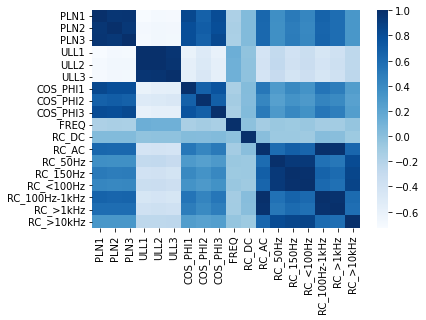

In [23]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [24]:
def create_sequece_dataloaders_new(dataset_norm, seq_length, batch_size):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of seq_length measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  assert seq_length > 1, f"sequence length should be greater than 1 expected, got: {seq_length}"

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - (seq_length +1))):    
    data = np.array(dataset_norm.iloc[i:i+seq_length, 1:])
    next = np.array(dataset_norm.iloc[i+seq_length, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+(seq_length + 1), 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=batch_size,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=batch_size,
      shuffle=True
  )

  return loader_train, loader_test

In [25]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm, 30, 16)

100%|██████████| 63329/63329 [00:47<00:00, 1325.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [ ]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [ ]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:32<00:00, 1920.92it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [ ]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

# save to npy file
if False:
  np.save('baseline_train.npy', losses_train)
  np.save('baseline_test.npy', losses_test)

Training set
Mean Loss of baselinemodel:  0.47340006590951506
Standard deviation Loss of baselinemodel:  0.1774038643188757


Test set
Mean Loss of baselinemodel:  0.46949629177047747
Standard deviation Loss of baselinemodel:  0.18327590880998915




In [ ]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [ ]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN , train_losses_FFN, test_losses_FFN = train(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

# save to npy file
if True:
  np.save('FFN_train.npy', losses_train)
  np.save('FFN_test.npy', losses_test)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Training time: 7.1e-05 seconds


In [ ]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_FFN))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_FFN], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

#min values in numpy array
minval = np.amin([np.mean(i) for i in test_losses_FFN])
print('min value in array:',minval)
indice = np.where([np.mean(i) for i in test_losses_FFN] == np.amin([np.mean(i) for i in test_losses_FFN]))
print('min value index:',indice[0])

NameError: ignored

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [26]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [27]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if False:
  np.save('Transformer_Vanilla_train.npy', train_losses_1)
  np.save('Transformer_Vanilla_test.npy', test_losses_1)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if train_transformer is True:
  np.save('Transformer_ADAM_train.npy', train_losses_2)
  np.save('Transformer_ADAM_test.npy', test_losses_2)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [64]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if True:
  np.save('Transformer_SGDmom_train.npy', train_losses_3)
  np.save('Transformer_SGDmom_test.npy', test_losses_3)
  files.download('Transformer_SGDmom_train.npy') 
  files.download('Transformer_SGDmom_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.42it/s]



Current Mean loss Train Set:  0.35455235590885903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.51it/s]



Current Mean loss Test Set:  0.36299624564972793


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.28it/s]



Current Mean loss Train Set:  0.3413375794402408

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.59it/s]



Current Mean loss Test Set:  0.34956692072628726


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.03it/s]



Current Mean loss Train Set:  0.33264936092292663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.93it/s]



Current Mean loss Test Set:  0.3402695669369264


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.31629573011160766

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.56it/s]



Current Mean loss Test Set:  0.3217611018982198


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.38it/s]



Current Mean loss Train Set:  0.3138207645938867

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.62it/s]



Current Mean loss Test Set:  0.3202352596428057


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.47it/s]



Current Mean loss Train Set:  0.29326423390792256

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.86it/s]



Current Mean loss Test Set:  0.29886065382096505


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.10it/s]



Current Mean loss Train Set:  0.2984167037345103

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.47it/s]



Current Mean loss Test Set:  0.30434685584270593


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.71it/s]



Current Mean loss Train Set:  0.28563362694158

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.82it/s]



Current Mean loss Test Set:  0.2908018588116675


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.23it/s]



Current Mean loss Train Set:  0.28396195229304966

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.63it/s]



Current Mean loss Test Set:  0.28994448328710565


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.20it/s]



Current Mean loss Train Set:  0.2764734483328958

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.61it/s]



Current Mean loss Test Set:  0.28304579451379147


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.52it/s]



Current Mean loss Train Set:  0.2737693801990661

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.79it/s]



Current Mean loss Test Set:  0.2817369338990462


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.92it/s]



Current Mean loss Train Set:  0.2711038654761605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.96it/s]



Current Mean loss Test Set:  0.27943743421047024


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.81it/s]



Current Mean loss Train Set:  0.26567205446274333

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.45it/s]



Current Mean loss Test Set:  0.2738732874318205


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.61it/s]



Current Mean loss Train Set:  0.26328192637261466

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.88it/s]



Current Mean loss Test Set:  0.27203465682087524


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.23it/s]



Current Mean loss Train Set:  0.2557202074054651

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.54it/s]



Current Mean loss Test Set:  0.2639703935369699


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.12it/s]



Current Mean loss Train Set:  0.24975384889970895

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.31it/s]



Current Mean loss Test Set:  0.25837321483501885


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.60it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.249299782880096

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.33it/s]



Current Mean loss Test Set:  0.2586183325020653


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.77it/s]



Current Mean loss Train Set:  0.2464478744751712

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.58it/s]



Current Mean loss Test Set:  0.2512914212514656


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.63it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.82it/s]



Current Mean loss Train Set:  0.24368755262185107

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.74it/s]



Current Mean loss Test Set:  0.2515919516521572


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.24170924895454785

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.07it/s]



Current Mean loss Test Set:  0.24837682023644447


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.66it/s]



Current Mean loss Train Set:  0.24301973538990274

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.28it/s]



Current Mean loss Test Set:  0.25060314986139837


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.68it/s]



Current Mean loss Train Set:  0.2403812778906109

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.47it/s]



Current Mean loss Test Set:  0.2460049626727899


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.79it/s]



Current Mean loss Train Set:  0.23810922423047762

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.29it/s]



Current Mean loss Test Set:  0.24392431645155555


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.07it/s]



Current Mean loss Train Set:  0.23927795612432298

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.52it/s]



Current Mean loss Test Set:  0.24678841856016656


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.85it/s]



Current Mean loss Train Set:  0.23949891096908926

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.2435394817342361


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.67it/s]



Current Mean loss Train Set:  0.23387234953056718

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.58it/s]



Current Mean loss Test Set:  0.24106845918177355


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.23160876354206286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.2398610736121132


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.10it/s]



Current Mean loss Train Set:  0.23445382416499252

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.69it/s]



Current Mean loss Test Set:  0.24229015377961627


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.99it/s]



Current Mean loss Train Set:  0.2369825246751961

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.53it/s]



Current Mean loss Test Set:  0.24473959606404255


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.06it/s]



Current Mean loss Train Set:  0.2339947152796034

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.60it/s]



Current Mean loss Test Set:  0.24228270237117705


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.96it/s]



Current Mean loss Train Set:  0.22984213372595752

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.33it/s]



Current Mean loss Test Set:  0.23915532370558892


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.41it/s]



Current Mean loss Train Set:  0.2330363385071923

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.59it/s]



Current Mean loss Test Set:  0.23993503859247825


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.88it/s]



Current Mean loss Train Set:  0.22931748735680527

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.85it/s]



Current Mean loss Test Set:  0.23785624148869755


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.71it/s]



Current Mean loss Train Set:  0.23175813128673525

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.16it/s]



Current Mean loss Test Set:  0.2413431518532411


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.18it/s]



Current Mean loss Train Set:  0.22878943112687453

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.44it/s]



Current Mean loss Test Set:  0.23856058647159975


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.38it/s]



Current Mean loss Train Set:  0.22965612582425338

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.63it/s]



Current Mean loss Test Set:  0.2396261694304871


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.87it/s]



Current Mean loss Train Set:  0.22747406234048304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 106.15it/s]



Current Mean loss Test Set:  0.23694958955501066


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.00it/s]



Current Mean loss Train Set:  0.22478594148331332

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.26it/s]



Current Mean loss Test Set:  0.23429222864032995


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.69it/s]



Current Mean loss Train Set:  0.22593683575039797

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.41it/s]



Current Mean loss Test Set:  0.2338082344092504


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.51it/s]



Current Mean loss Train Set:  0.22459929985567456

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.85it/s]



Current Mean loss Test Set:  0.23545502060365797


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.26it/s]



Current Mean loss Train Set:  0.22448164446699195

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.74it/s]



Current Mean loss Test Set:  0.23271361653777686


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.26it/s]



Current Mean loss Train Set:  0.2257264419833897

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.83it/s]



Current Mean loss Test Set:  0.23712955117978232


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 104.86it/s]



Current Mean loss Train Set:  0.22767089642929356

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.32it/s]



Current Mean loss Test Set:  0.23712343365104513


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.47it/s]



Current Mean loss Train Set:  0.22124409695254463

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.34it/s]



Current Mean loss Test Set:  0.23086606504188645


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.99it/s]



Current Mean loss Train Set:  0.22572807143352155

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.33it/s]



Current Mean loss Test Set:  0.2339917111840814


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.38it/s]



Current Mean loss Train Set:  0.2289084335943303

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.13it/s]



Current Mean loss Test Set:  0.2420885953864064


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.20it/s]



Current Mean loss Train Set:  0.22194688947656468

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.57it/s]



Current Mean loss Test Set:  0.2326932939691375


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.40it/s]



Current Mean loss Train Set:  0.2237357451859365

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.44it/s]



Current Mean loss Test Set:  0.23467654189226603


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:33<00:00, 105.59it/s]



Current Mean loss Train Set:  0.22004342228676074

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.79it/s]



Current Mean loss Test Set:  0.23194065881949483


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.58it/s]



Current Mean loss Train Set:  0.22002920937477924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.90it/s]



Current Mean loss Test Set:  0.2307062279809304


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:46<00:00, 33.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.53it/s]



Current Mean loss Train Set:  0.21869713702447421

Test with test set


100%|██████████| 396/396 [00:03<00:00, 104.20it/s]



Current Mean loss Test Set:  0.22957186120552847


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 104.68it/s]



Current Mean loss Train Set:  0.21802188530083355

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.01it/s]



Current Mean loss Test Set:  0.22991632914753876


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.69it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.22it/s]



Current Mean loss Train Set:  0.22019325000807172

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.05it/s]



Current Mean loss Test Set:  0.23163744216464988


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.99it/s]



Current Mean loss Train Set:  0.21897460052488962

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.36it/s]



Current Mean loss Test Set:  0.23007761327681517


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.56it/s]



Current Mean loss Train Set:  0.21831014583636427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.61it/s]



Current Mean loss Test Set:  0.23061229218964022


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.49it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.18it/s]



Current Mean loss Train Set:  0.22142184666668202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.43it/s]



Current Mean loss Test Set:  0.23101013460469366


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.56it/s]



Current Mean loss Train Set:  0.21749904418456698

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.91it/s]



Current Mean loss Test Set:  0.23080106909302148


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.65it/s]



Current Mean loss Train Set:  0.2178809177104322

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.22it/s]



Current Mean loss Test Set:  0.23154203100788473


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.39it/s]



Current Mean loss Train Set:  0.21605639775298532

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.03it/s]



Current Mean loss Test Set:  0.22735873257948291


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.61it/s]



Current Mean loss Train Set:  0.21654751633798142

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.93it/s]



Current Mean loss Test Set:  0.23068153991768456


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.06it/s]



Current Mean loss Train Set:  0.21606055334306587

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.19it/s]



Current Mean loss Test Set:  0.22707283617270113


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.00it/s]



Current Mean loss Train Set:  0.21840878653410878

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.99it/s]



Current Mean loss Test Set:  0.23268168398903477


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.66it/s]



Current Mean loss Train Set:  0.21841977563026144

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.44it/s]



Current Mean loss Test Set:  0.2294209601000102


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.39it/s]



Current Mean loss Train Set:  0.21572865749004347

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22905767063676108


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.73it/s]



Current Mean loss Train Set:  0.21738662445039988

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.09it/s]



Current Mean loss Test Set:  0.23064433950742688


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.26it/s]



Current Mean loss Train Set:  0.21515888019814908

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.70it/s]



Current Mean loss Test Set:  0.22917436392545099


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.61it/s]



Current Mean loss Train Set:  0.21302510253873863

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.95it/s]



Current Mean loss Test Set:  0.22462724847248708


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:47<00:00, 33.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.21654244676470724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.68it/s]



Current Mean loss Test Set:  0.22854404636856282


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.04it/s]



Current Mean loss Train Set:  0.21926662680090997

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.38it/s]



Current Mean loss Test Set:  0.2320859707854312


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.99it/s]



Current Mean loss Train Set:  0.21256924913257755

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.75it/s]



Current Mean loss Test Set:  0.2242167614814308


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.79it/s]



Current Mean loss Train Set:  0.21632429404085418

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.38it/s]



Current Mean loss Test Set:  0.2308395193381743


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.02it/s]



Current Mean loss Train Set:  0.21226675763052902

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.15it/s]



Current Mean loss Test Set:  0.22677400708198547


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.74it/s]



Current Mean loss Train Set:  0.21184761987002151

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.44it/s]



Current Mean loss Test Set:  0.22681501639461277


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.48it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.54it/s]



Current Mean loss Train Set:  0.2132643228174594

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.72it/s]



Current Mean loss Test Set:  0.22751549911694696


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.22it/s] 



Current Mean loss Train Set:  0.21967030520473274

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.85it/s]



Current Mean loss Test Set:  0.23116451351329534


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.49it/s]



Current Mean loss Train Set:  0.21415352886383232

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.70it/s]



Current Mean loss Test Set:  0.22676264346022196


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.94it/s]



Current Mean loss Train Set:  0.21689984965635556

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.06it/s] 



Current Mean loss Test Set:  0.23422287007549195


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.57it/s] 



Current Mean loss Train Set:  0.21207431659892875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.35it/s]



Current Mean loss Test Set:  0.2285770271537882


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.68it/s]



Current Mean loss Train Set:  0.21057355950722156

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.00it/s]



Current Mean loss Test Set:  0.22454103731522054


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.14it/s]



Current Mean loss Train Set:  0.21201632747548435

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.12it/s]



Current Mean loss Test Set:  0.2265559116547758


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.10it/s]



Current Mean loss Train Set:  0.21064039414689475

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.19it/s]



Current Mean loss Test Set:  0.224512599201666


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.87it/s] 



Current Mean loss Train Set:  0.21558375461505364

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.50it/s] 



Current Mean loss Test Set:  0.23011390230797155


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.12it/s]



Current Mean loss Train Set:  0.21030427788604086

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.60it/s]



Current Mean loss Test Set:  0.2279014497656714


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.25it/s]



Current Mean loss Train Set:  0.20801493374109603

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.43it/s]



Current Mean loss Test Set:  0.2233969931951677


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.37it/s]



Current Mean loss Train Set:  0.20973108684810868

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.57it/s]



Current Mean loss Test Set:  0.22400392375585407


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.33it/s]



Current Mean loss Train Set:  0.2088738064684963

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.59it/s] 



Current Mean loss Test Set:  0.2260320893479417


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.68it/s]



Current Mean loss Train Set:  0.20860539361470676

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.70it/s]



Current Mean loss Test Set:  0.22371387175011515


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.82it/s]



Current Mean loss Train Set:  0.20822784722211019

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.75it/s]



Current Mean loss Test Set:  0.22374096567356827


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.03it/s]



Current Mean loss Train Set:  0.20900366043161214

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.51it/s]



Current Mean loss Test Set:  0.22426621800269744


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.63it/s] 



Current Mean loss Train Set:  0.20776819530377855

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.50it/s] 



Current Mean loss Test Set:  0.22363578140585108


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.97it/s]



Current Mean loss Train Set:  0.2081456954099307

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.15it/s]



Current Mean loss Test Set:  0.22532557348033996


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.41it/s]



Current Mean loss Train Set:  0.21063884506391536

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.25it/s] 



Current Mean loss Test Set:  0.22620496114320826


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.42it/s] 



Current Mean loss Train Set:  0.20826357325793585

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.23it/s]



Current Mean loss Test Set:  0.22498411196048815


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.15it/s]



Current Mean loss Train Set:  0.2093918390013748

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.97it/s]



Current Mean loss Test Set:  0.22760816898686115


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.45it/s]



Current Mean loss Train Set:  0.20869359144443814

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.78it/s]



Current Mean loss Test Set:  0.22354040439758036


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.87it/s]



Current Mean loss Train Set:  0.20678003806094924

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.42it/s]



Current Mean loss Test Set:  0.22352268924993096


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.09it/s]



Current Mean loss Train Set:  0.2070320225162617

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.91it/s]



Current Mean loss Test Set:  0.22411971894854849


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.34it/s]



Current Mean loss Train Set:  0.20567504729141922

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.19it/s]



Current Mean loss Test Set:  0.22270121180800476


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.06it/s]



Current Mean loss Train Set:  0.20737756615796854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.19it/s]



Current Mean loss Test Set:  0.22340666536580434


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.40it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.2085448814775045

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.89it/s]



Current Mean loss Test Set:  0.22621732530645047


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.96it/s]



Current Mean loss Train Set:  0.2065067589659387

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.54it/s]



Current Mean loss Test Set:  0.22321129633546477


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.22it/s]



Current Mean loss Train Set:  0.20417747655561924

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.72it/s]



Current Mean loss Test Set:  0.22238585772463168


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.87it/s]



Current Mean loss Train Set:  0.20514289752263687

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.05it/s]



Current Mean loss Test Set:  0.22102553645769754


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.11it/s]



Current Mean loss Train Set:  0.20825009681796747

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.14it/s]



Current Mean loss Test Set:  0.22480743165795852


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.04it/s]



Current Mean loss Train Set:  0.20391437977159288

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.44it/s]



Current Mean loss Test Set:  0.2216262642595202


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.28it/s]



Current Mean loss Train Set:  0.20684452513622295

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.93it/s]



Current Mean loss Test Set:  0.22556323565617956


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.62it/s]



Current Mean loss Train Set:  0.20822192218918964

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.80it/s]



Current Mean loss Test Set:  0.22670806594418758


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.83it/s]



Current Mean loss Train Set:  0.20526109417310232

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.60it/s]



Current Mean loss Test Set:  0.2211140530616647


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.88it/s]



Current Mean loss Train Set:  0.20260979046555272

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.55it/s]



Current Mean loss Test Set:  0.22040076085338087


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.98it/s]



Current Mean loss Train Set:  0.2045448786073811

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.22246795123198418


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.05it/s]



Current Mean loss Train Set:  0.20697692086396846

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.27it/s]



Current Mean loss Test Set:  0.22495600229336155


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.2056952073475868

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.96it/s]



Current Mean loss Test Set:  0.22266208118937833


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.26it/s]



Current Mean loss Train Set:  0.20290201287815954

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.49it/s]



Current Mean loss Test Set:  0.22246950706749252


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.77it/s]



Current Mean loss Train Set:  0.20340505434310474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.83it/s]



Current Mean loss Test Set:  0.22142194412799196


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.40it/s]



Current Mean loss Train Set:  0.2038146811938674

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.89it/s] 



Current Mean loss Test Set:  0.2242818001206174


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.01it/s]



Current Mean loss Train Set:  0.204520374530241

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.30it/s]



Current Mean loss Test Set:  0.2240137266314993


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.52it/s]



Current Mean loss Train Set:  0.205203956345929

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.93it/s]



Current Mean loss Test Set:  0.22412198343587042


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.33it/s]



Current Mean loss Train Set:  0.20337396588070888

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22129668120407697


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.34it/s]



Current Mean loss Train Set:  0.20468139121690027

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.47it/s]



Current Mean loss Test Set:  0.22314637026401482


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.20397168474228503

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.24it/s]



Current Mean loss Test Set:  0.22386040670251606


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.51it/s]



Current Mean loss Train Set:  0.20022807926056663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.55it/s]



Current Mean loss Test Set:  0.22217239661499708


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.98it/s]



Current Mean loss Train Set:  0.20307459990872181

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.79it/s]



Current Mean loss Test Set:  0.2244351850540349


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.54it/s]



Current Mean loss Train Set:  0.20186558065749338

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.13it/s]



Current Mean loss Test Set:  0.2219173734386762


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.20it/s]



Current Mean loss Train Set:  0.200588827699197

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.34it/s]



Current Mean loss Test Set:  0.22213993750211566


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.18it/s]



Current Mean loss Train Set:  0.2034926208286616

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.83it/s]



Current Mean loss Test Set:  0.22509614494864386


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.20it/s]



Current Mean loss Train Set:  0.20183891638456822

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.87it/s]



Current Mean loss Test Set:  0.22240527333560015


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.46it/s]



Current Mean loss Train Set:  0.20055050993614776

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.83it/s]



Current Mean loss Test Set:  0.22097796995681945


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.75it/s]



Current Mean loss Train Set:  0.2031873348653902

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.42it/s]



Current Mean loss Test Set:  0.22373681910561793


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.46it/s]



Current Mean loss Train Set:  0.20015292379659044

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.73it/s]



Current Mean loss Test Set:  0.22107633412110084


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.34it/s]



Current Mean loss Train Set:  0.20014317123333858

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.91it/s]



Current Mean loss Test Set:  0.21974106708710844


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.24it/s]



Current Mean loss Train Set:  0.2049748982471962

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.94it/s]



Current Mean loss Test Set:  0.22491761518999784


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.59it/s]



Current Mean loss Train Set:  0.20188419400616842

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.66it/s]



Current Mean loss Test Set:  0.22235697536080173


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.66it/s]



Current Mean loss Train Set:  0.2007126067583393

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.12it/s]



Current Mean loss Test Set:  0.22286218337037347


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.96it/s]



Current Mean loss Train Set:  0.20285628392242697

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.16it/s]



Current Mean loss Test Set:  0.22479776669331272


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.75it/s]



Current Mean loss Train Set:  0.19971885273471965

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.98it/s]



Current Mean loss Test Set:  0.22283890111503576


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.85it/s]



Current Mean loss Train Set:  0.1993683355262097

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.58it/s]



Current Mean loss Test Set:  0.2235223458647126


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.06it/s]



Current Mean loss Train Set:  0.20186444988603375

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.56it/s]



Current Mean loss Test Set:  0.22558271636565527


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.87it/s]



Current Mean loss Train Set:  0.19988767631245302

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.95it/s]



Current Mean loss Test Set:  0.22061891372155662


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.53it/s]



Current Mean loss Train Set:  0.19947107906400774

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.30it/s]



Current Mean loss Test Set:  0.22173823241257307


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.69it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.82it/s]



Current Mean loss Train Set:  0.19814824592295974

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.23it/s]



Current Mean loss Test Set:  0.2197613479625998


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.97it/s]



Current Mean loss Train Set:  0.19880343043516432

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.71it/s]



Current Mean loss Test Set:  0.22121290288715048


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.25it/s]



Current Mean loss Train Set:  0.19911570821732175

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.84it/s]



Current Mean loss Test Set:  0.2191225267909091


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.54it/s] 



Current Mean loss Train Set:  0.19986068806787438

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.51it/s] 



Current Mean loss Test Set:  0.22164122017119267


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.65it/s]



Current Mean loss Train Set:  0.19852912974698872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.13it/s]



Current Mean loss Test Set:  0.2200284952655284


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.45it/s]



Current Mean loss Train Set:  0.1982705744337306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.43it/s]



Current Mean loss Test Set:  0.22270836799659513


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.56it/s]



Current Mean loss Train Set:  0.19848536994645946

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.00it/s]



Current Mean loss Test Set:  0.22352244260937276


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.70it/s]



Current Mean loss Train Set:  0.19779715637477502

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.66it/s]



Current Mean loss Test Set:  0.2224315894071502


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 103.53it/s]



Current Mean loss Train Set:  0.19851131475426795

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.81it/s]



Current Mean loss Test Set:  0.22212356191617671


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.26it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.66it/s]



Current Mean loss Train Set:  0.19899619707365634

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.87it/s]



Current Mean loss Test Set:  0.2213557262086507


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.63it/s]



Current Mean loss Train Set:  0.19684159208257446

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.99it/s]



Current Mean loss Test Set:  0.21825807665785155


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.22it/s]



Current Mean loss Train Set:  0.19874981495308935

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.21it/s]



Current Mean loss Test Set:  0.21913185521885


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:48<00:00, 32.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.71it/s]



Current Mean loss Train Set:  0.19873353639220775

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.90it/s]



Current Mean loss Test Set:  0.22312321387833417


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:49<00:00, 32.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.95it/s]



Current Mean loss Train Set:  0.19771442812855178

Test with test set


100%|██████████| 396/396 [00:03<00:00, 102.85it/s]



Current Mean loss Test Set:  0.22170990009350006


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.98it/s]



Current Mean loss Train Set:  0.19688386833721286

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.41it/s]



Current Mean loss Test Set:  0.2207087038668117


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.71it/s]



Current Mean loss Train Set:  0.19729224240724672

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.02it/s]



Current Mean loss Test Set:  0.22167263323008413


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.40it/s]



Current Mean loss Train Set:  0.19758361735865537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.92it/s]



Current Mean loss Test Set:  0.22391648980026896


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.91it/s] 



Current Mean loss Train Set:  0.19611750242626805

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.29it/s] 



Current Mean loss Test Set:  0.22121684650203796


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.45it/s]



Current Mean loss Train Set:  0.19632822411919523

Test with test set


100%|██████████| 396/396 [00:04<00:00, 96.58it/s]



Current Mean loss Test Set:  0.22362499830849242


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.03it/s] 



Current Mean loss Train Set:  0.19769497094045954

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.29it/s]



Current Mean loss Test Set:  0.22330437103907266


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.86it/s]



Current Mean loss Train Set:  0.19741763933393147

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.73it/s] 



Current Mean loss Test Set:  0.22393832807288025


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.15it/s]



Current Mean loss Train Set:  0.19741663882530308

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.24it/s]



Current Mean loss Test Set:  0.22172474689932184


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.04it/s]



Current Mean loss Train Set:  0.19698236120272444

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.10it/s]



Current Mean loss Test Set:  0.22400158241090148


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.88it/s]



Current Mean loss Train Set:  0.19553610512690367

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.96it/s]



Current Mean loss Test Set:  0.2205866693584907


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.94it/s]



Current Mean loss Train Set:  0.19622305541218515

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.21it/s]



Current Mean loss Test Set:  0.22239786860617725


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.46it/s]



Current Mean loss Train Set:  0.19772986865908518

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.58it/s]



Current Mean loss Test Set:  0.22464162758504502


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.10it/s]



Current Mean loss Train Set:  0.1981014451061679

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.44it/s]



Current Mean loss Test Set:  0.2244584116746079


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.61it/s] 



Current Mean loss Train Set:  0.19638326664570507

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.75it/s] 



Current Mean loss Test Set:  0.22161454498542077


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.73it/s]



Current Mean loss Train Set:  0.195368155494119

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.31it/s]



Current Mean loss Test Set:  0.21982156411942208


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.47it/s]



Current Mean loss Train Set:  0.19477001347595008

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.38it/s]



Current Mean loss Test Set:  0.22180630592158948


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.25it/s]



Current Mean loss Train Set:  0.1993249845310707

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.22221305396294955


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.50it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.83it/s]



Current Mean loss Train Set:  0.19418545179602273

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.49it/s]



Current Mean loss Test Set:  0.22121645301354653


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.02it/s]



Current Mean loss Train Set:  0.19527230772900508

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.64it/s]



Current Mean loss Test Set:  0.22313423221460496


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.45it/s]



Current Mean loss Train Set:  0.19657621012413531

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.76it/s] 



Current Mean loss Test Set:  0.22289489518211344


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.10it/s]



Current Mean loss Train Set:  0.19311189064518172

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.85it/s]



Current Mean loss Test Set:  0.22054866622343208


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.96it/s]



Current Mean loss Train Set:  0.19575359871589565

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.44it/s]



Current Mean loss Test Set:  0.2196324300209079


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 32.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.14it/s]



Current Mean loss Train Set:  0.19377242271280543

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.49it/s]



Current Mean loss Test Set:  0.22228297788762685


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.62it/s]



Current Mean loss Train Set:  0.19353372619547202

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.73it/s]



Current Mean loss Test Set:  0.21898251655276377


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.80it/s]



Current Mean loss Train Set:  0.1940894968266103

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.22309170710393275


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.17it/s]



Current Mean loss Train Set:  0.19468217016671635

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.73it/s]



Current Mean loss Test Set:  0.22145175931956432


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.53it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.83it/s]



Current Mean loss Train Set:  0.19334841433859193

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.91it/s]



Current Mean loss Test Set:  0.22036150769528115


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.50it/s]



Current Mean loss Train Set:  0.19450566445278913

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.06it/s]



Current Mean loss Test Set:  0.22255594147877258


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:52<00:00, 31.74it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.44it/s] 



Current Mean loss Train Set:  0.1964345897558095

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.83it/s]



Current Mean loss Test Set:  0.224290775906558


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.76it/s]



Current Mean loss Train Set:  0.19297632226240022

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.56it/s]



Current Mean loss Test Set:  0.2204639393873889


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.65it/s] 



Current Mean loss Train Set:  0.1924534348680536

Test with test set


100%|██████████| 396/396 [00:04<00:00, 98.74it/s] 



Current Mean loss Test Set:  0.21843479556793516


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.92it/s]



Current Mean loss Train Set:  0.1930272773644277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.2214150485780203


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.81it/s]



Current Mean loss Train Set:  0.19319287156192164

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.63it/s]



Current Mean loss Test Set:  0.21992551832638604


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 100.42it/s]



Current Mean loss Train Set:  0.19166030543442025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.77it/s] 



Current Mean loss Test Set:  0.2198480890894478


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.27it/s]



Current Mean loss Train Set:  0.19243443180780012

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.99it/s]



Current Mean loss Test Set:  0.2222455134333083


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 102.14it/s]



Current Mean loss Train Set:  0.19453419357278928

Test with test set


100%|██████████| 396/396 [00:03<00:00, 103.76it/s]



Current Mean loss Test Set:  0.22453924885602913


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.73it/s]



Current Mean loss Train Set:  0.19402349667496605

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.71it/s]



Current Mean loss Test Set:  0.22149747943110537


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.79it/s]



Current Mean loss Train Set:  0.195739987274669

Test with test set


100%|██████████| 396/396 [00:03<00:00, 100.04it/s]



Current Mean loss Test Set:  0.22329546765170313


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 101.35it/s]



Current Mean loss Train Set:  0.19296692240248228

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.17it/s]



Current Mean loss Test Set:  0.222268816723366


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:50<00:00, 32.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:34<00:00, 101.82it/s]



Current Mean loss Train Set:  0.19203997142623389

Test with test set


100%|██████████| 396/396 [00:03<00:00, 101.19it/s]



Current Mean loss Test Set:  0.22030445464858503


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:51<00:00, 31.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:35<00:00, 99.58it/s]



Current Mean loss Train Set:  0.19547713967628302

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.02it/s]



Current Mean loss Test Set:  0.2235216408441163


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:54<00:00, 31.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.90it/s]



Current Mean loss Train Set:  0.19231391484202745

Test with test set


100%|██████████| 396/396 [00:04<00:00, 95.67it/s]



Current Mean loss Test Set:  0.2207348459409644


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:53<00:00, 31.47it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.63it/s]



Current Mean loss Train Set:  0.19335715008892773

Test with test set


100%|██████████| 396/396 [00:04<00:00, 96.56it/s]



Current Mean loss Test Set:  0.22028499924474293


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:55<00:00, 30.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 97.39it/s] 



Current Mean loss Train Set:  0.19497941620281964

Test with test set


100%|██████████| 396/396 [00:04<00:00, 97.02it/s]



Current Mean loss Test Set:  0.22455273081332144


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:57<00:00, 30.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:37<00:00, 95.82it/s]



Current Mean loss Train Set:  0.1920262084013453

Test with test set


100%|██████████| 396/396 [00:04<00:00, 93.99it/s]



Current Mean loss Test Set:  0.2207831054587256


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:56<00:00, 30.70it/s]



Test with training set


100%|██████████| 3563/3563 [00:36<00:00, 98.60it/s]



Current Mean loss Train Set:  0.19250371358784737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 99.36it/s] 



Current Mean loss Test Set:  0.22393987976917715


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:57<00:00, 30.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:37<00:00, 95.86it/s]



Current Mean loss Train Set:  0.19174649742273275

Test with test set


100%|██████████| 396/396 [00:04<00:00, 95.68it/s]



Current Mean loss Test Set:  0.2212627154746742


29752447.716 miliseconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: ignored

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_small_train.npy', train_losses_4)
  np.save('Transformer_small_test.npy', test_losses_4)
  files.download('Transformer_small_train.npy') 
  files.download('Transformer_small_test.npy') 

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)
  files.download('Transformer_big_train.npy') 
  files.download('Transformer_big_test.npy') 

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [33]:
loader_train_seq_short, loader_test_seq_short = create_sequece_dataloaders_new(dataset_norm, 15, 16)

100%|██████████| 63344/63344 [00:41<00:00, 1529.11it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 57009
length of test set (whole dataset): 6335




In [34]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_short, train_losses_short, test_losses_short = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_short, 
      test_loader= loader_test_seq_short, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_shortseq_train.npy', train_losses_short)
  np.save('Transformer_shortseq_test.npy', test_losses_short)
  files.download('Transformer_shortseq_train.npy') 
  files.download('Transformer_shortseq_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3564/3564 [01:29<00:00, 40.00it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 138.23it/s]



Current Mean loss Train Set:  0.35778254306510376

Test with test set


100%|██████████| 396/396 [00:02<00:00, 136.33it/s]



Current Mean loss Test Set:  0.347094971950006


Epoch: 2 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.44it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 139.81it/s]



Current Mean loss Train Set:  0.3409532145476836

Test with test set


100%|██████████| 396/396 [00:02<00:00, 141.76it/s]



Current Mean loss Test Set:  0.33139172651701504


Epoch: 3 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.37it/s]



Test with training set


100%|██████████| 3564/3564 [00:26<00:00, 135.92it/s]



Current Mean loss Train Set:  0.3248378017469906

Test with test set


100%|██████████| 396/396 [00:03<00:00, 128.50it/s]



Current Mean loss Test Set:  0.3174597368848444


Epoch: 4 of 200
Training...


100%|██████████| 3564/3564 [01:29<00:00, 39.97it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 137.91it/s]



Current Mean loss Train Set:  0.30695137083446805

Test with test set


100%|██████████| 396/396 [00:02<00:00, 137.91it/s]



Current Mean loss Test Set:  0.29922878019737476


Epoch: 5 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.32it/s]



Test with training set


100%|██████████| 3564/3564 [00:26<00:00, 135.87it/s]



Current Mean loss Train Set:  0.28996767904128623

Test with test set


100%|██████████| 396/396 [00:02<00:00, 134.32it/s]



Current Mean loss Test Set:  0.2813628578953671


Epoch: 6 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.18it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 137.50it/s]



Current Mean loss Train Set:  0.2907757669055937

Test with test set


100%|██████████| 396/396 [00:02<00:00, 135.21it/s]



Current Mean loss Test Set:  0.28271561810238793


Epoch: 7 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.19it/s]



Test with training set


100%|██████████| 3564/3564 [00:26<00:00, 136.15it/s]



Current Mean loss Train Set:  0.2832001059574277

Test with test set


100%|██████████| 396/396 [00:02<00:00, 138.18it/s]



Current Mean loss Test Set:  0.27380430254370275


Epoch: 8 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.27it/s]



Test with training set


100%|██████████| 3564/3564 [00:26<00:00, 135.85it/s]



Current Mean loss Train Set:  0.27352485423813566

Test with test set


100%|██████████| 396/396 [00:02<00:00, 138.14it/s]



Current Mean loss Test Set:  0.2659822155279343


Epoch: 9 of 200
Training...


100%|██████████| 3564/3564 [01:29<00:00, 40.02it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 137.78it/s]



Current Mean loss Train Set:  0.28376005016116784

Test with test set


100%|██████████| 396/396 [00:02<00:00, 136.73it/s]



Current Mean loss Test Set:  0.2746546105340575


Epoch: 10 of 200
Training...


100%|██████████| 3564/3564 [01:28<00:00, 40.23it/s]



Test with training set


100%|██████████| 3564/3564 [00:25<00:00, 137.37it/s]



Current Mean loss Train Set:  0.26246805874762513

Test with test set


100%|██████████| 396/396 [00:02<00:00, 140.97it/s]



Current Mean loss Test Set:  0.25399820288323394


Epoch: 11 of 200
Training...


100%|██████████| 3564/3564 [01:31<00:00, 39.14it/s]



Test with training set


100%|██████████| 3564/3564 [00:26<00:00, 136.97it/s]



Current Mean loss Train Set:  0.2682927225190649

Test with test set


100%|██████████| 396/396 [00:02<00:00, 139.97it/s]



Current Mean loss Test Set:  0.2602221655913375


Epoch: 12 of 200
Training...


 77%|███████▋  | 2739/3564 [01:07<00:20, 40.51it/s]


KeyboardInterrupt: ignored

In [35]:
loader_train_seq_long, loader_test_seq_long = create_sequece_dataloaders_new(dataset_norm, 60, 16)

100%|██████████| 63299/63299 [00:38<00:00, 1657.44it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56969
length of test set (whole dataset): 6330




In [36]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_long, train_losses_long, test_losses_long = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_long, 
      test_loader= loader_test_seq_long, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_longseq_train.npy', train_losses_long)
  np.save('Transformer_longseq_test.npy', test_losses_long)
  files.download('Transformer_longseq_train.npy') 
  files.download('Transformer_longseq_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3561/3561 [01:48<00:00, 32.76it/s]



Test with training set


100%|██████████| 3561/3561 [00:41<00:00, 85.50it/s]



Current Mean loss Train Set:  0.34977058873388145

Test with test set


100%|██████████| 396/396 [00:04<00:00, 85.00it/s]



Current Mean loss Test Set:  0.3519848460199857


Epoch: 2 of 200
Training...


100%|██████████| 3561/3561 [01:46<00:00, 33.43it/s]



Test with training set


100%|██████████| 3561/3561 [00:41<00:00, 86.00it/s]



Current Mean loss Train Set:  0.338088608200682

Test with test set


100%|██████████| 396/396 [00:04<00:00, 84.41it/s]



Current Mean loss Test Set:  0.3412612145672543


Epoch: 3 of 200
Training...


100%|██████████| 3561/3561 [01:47<00:00, 33.26it/s]



Test with training set


100%|██████████| 3561/3561 [00:42<00:00, 84.57it/s]



Current Mean loss Train Set:  0.3351912399279505

Test with test set


100%|██████████| 396/396 [00:04<00:00, 84.41it/s]



Current Mean loss Test Set:  0.3385061717620402


Epoch: 4 of 200
Training...


100%|██████████| 3561/3561 [01:47<00:00, 33.20it/s]



Test with training set


100%|██████████| 3561/3561 [00:41<00:00, 85.78it/s]



Current Mean loss Train Set:  0.3314065012125713

Test with test set


100%|██████████| 396/396 [00:04<00:00, 86.71it/s]



Current Mean loss Test Set:  0.3359854117111124


Epoch: 5 of 200
Training...


100%|██████████| 3561/3561 [01:46<00:00, 33.53it/s]



Test with training set


100%|██████████| 3561/3561 [00:42<00:00, 84.60it/s]



Current Mean loss Train Set:  0.32889113913122037

Test with test set


100%|██████████| 396/396 [00:04<00:00, 84.64it/s]



Current Mean loss Test Set:  0.3333268662670044


Epoch: 6 of 200
Training...


100%|██████████| 3561/3561 [01:48<00:00, 32.95it/s]



Test with training set


100%|██████████| 3561/3561 [00:40<00:00, 86.88it/s]



Current Mean loss Train Set:  0.3227725488245404

Test with test set


100%|██████████| 396/396 [00:04<00:00, 86.64it/s]



Current Mean loss Test Set:  0.32589663038350114


Epoch: 7 of 200
Training...


 58%|█████▊    | 2057/3561 [01:00<00:44, 33.83it/s]


KeyboardInterrupt: ignored

In [37]:
loader_train_seq_veryshort, loader_test_seq_veryshort = create_sequece_dataloaders_new(dataset_norm, 2, 16)

100%|██████████| 63357/63357 [00:44<00:00, 1418.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 57021
length of test set (whole dataset): 6336




In [38]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_veryshort, train_losses_veryshort, test_losses_veryshort = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_veryshort, 
      test_loader= loader_test_seq_veryshort, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_veryshort_train.npy', train_losses_veryshort)
  np.save('Transformer_veryshort_test.npy', test_losses_veryshort)
  files.download('Transformer_veryshort_train.npy') 
  files.download('Transformer_veryshort_test.npy') 

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3564/3564 [01:18<00:00, 45.66it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 187.79it/s]



Current Mean loss Train Set:  0.3450235106828638

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.62it/s]



Current Mean loss Test Set:  0.3478867364200679


Epoch: 2 of 200
Training...


100%|██████████| 3564/3564 [01:17<00:00, 46.24it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.48it/s]



Current Mean loss Train Set:  0.32581925634232034

Test with test set


100%|██████████| 396/396 [00:02<00:00, 191.77it/s]



Current Mean loss Test Set:  0.3284877904436805


Epoch: 3 of 200
Training...


100%|██████████| 3564/3564 [01:17<00:00, 46.16it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.35it/s]



Current Mean loss Train Set:  0.31996177427479044

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.12it/s]



Current Mean loss Test Set:  0.32185319096151027


Epoch: 4 of 200
Training...


100%|██████████| 3564/3564 [01:17<00:00, 46.17it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 189.82it/s]



Current Mean loss Train Set:  0.3136601903581392

Test with test set


100%|██████████| 396/396 [00:02<00:00, 189.56it/s]



Current Mean loss Test Set:  0.31570686335967046


Epoch: 5 of 200
Training...


100%|██████████| 3564/3564 [01:16<00:00, 46.40it/s]



Test with training set


100%|██████████| 3564/3564 [00:18<00:00, 188.92it/s]



Current Mean loss Train Set:  0.3149043090858912

Test with test set


100%|██████████| 396/396 [00:02<00:00, 185.07it/s]



Current Mean loss Test Set:  0.31638457313782037


Epoch: 6 of 200
Training...


 91%|█████████ | 3248/3564 [01:10<00:06, 46.28it/s]


KeyboardInterrupt: ignored

# Train RNN

In [ ]:
class ElmanRNN(torch.nn.Module):
    """
    Elman RNN tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(ElmanRNN, self).__init__()
        self.rnn1 = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.rnn1.hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.rnn1(x)
        return self.fc1(x)

In [ ]:
def training_RNN(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)

In [ ]:
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))
    
for model in (model_FFN, model_transformer):
    print(f'The "{type(model).__name__}" comprises "{count_parameters(model)}" trainable parameters.')

The "ANN_relu" comprises "237898" trainable parameters.
The "Transformer" comprises "542042" trainable parameters.


# Training using PCA in the dataset

In [ ]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [ ]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored

In [62]:
from google.colab import files
files.download('README.md') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>